In [1]:
import logging
import numpy as np
import pandas as pd
from arch import arch_model
from random import gauss
from random import seed
from matplotlib import pyplot as plt
import scipy.stats as sts
import json
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from scipy.optimize import least_squares
import os

In [2]:
ini_wd = os.getcwd()
os.chdir('..')

In [3]:
from rules_related import combine_rules_outputs
from whole_algorithm import train_model
from auxiliary import calc_log_returns, unpack_1d_parameters
from multivariate_normal_distribution import LongMultivariateNormal
from model import FuzzyVolatilityModel
from membership_functions import calc_trapezoidal_membership_degrees
from clusterization.all_methods import cluster_data_1d, cluster_data
from local_models import calc_cond_var_fuzzy
# from membership_functions.trapezoidal import _calc_trapezoidal_md_scalar

In [4]:
with open('config.json') as file:
    config = json.load(file)

In [5]:
files_folder = config['files_folders']['processed']
logs_folder = config['files_folders']['logs']

In [6]:
logging.basicConfig(level=logging.DEBUG,
                    filename=f'{logs_folder}/seasonal_testing.log',
                    filemode='w',
                    format='%(asctime)s,%(msecs)d %(name)s %(levelname)s %(message)s',
                    datefmt='%H:%M:%S')

In [7]:
pd.options.display.max_colwidth = 500

# Reading files

In [8]:
rtsi = pd.read_pickle(f'{files_folder}/rtsi.pkl')

In [9]:
rtsi

,<OPEN>,<HIGH>,<LOW>,<CLOSE>,<VOL>,return,log return
<DATE>,,,,,,,
2001-02-18,180.10,180.10,180.10,180.10,0,0.000000,0.000000
2001-02-19,180.10,181.21,176.67,177.29,0,-0.015602,-0.015725
2001-02-20,177.29,179.90,175.28,176.45,0,-0.004738,-0.004749
2001-02-21,176.45,176.45,161.12,162.39,0,-0.079683,-0.083037
2001-02-22,162.39,168.35,162.39,168.31,0,0.036455,0.035807
...,...,...,...,...,...,...,...
2021-10-11,1871.73,1883.71,1867.58,1882.43,1769145502,0.011537,0.011471
2021-10-12,1867.15,1876.79,1860.64,1869.94,1386130631,-0.006635,-0.006657
2021-10-13,1869.05,1869.05,1835.80,1855.11,1830447018,-0.007931,-0.007962


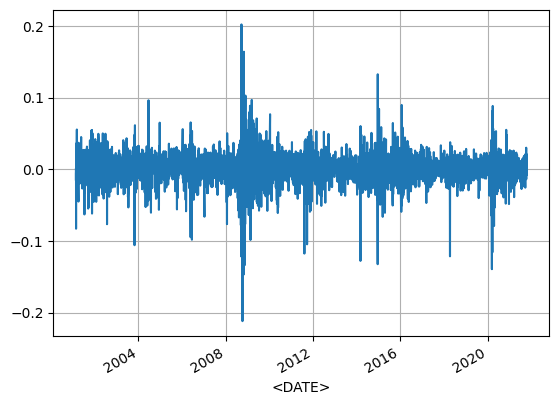

In [10]:
rtsi['log return'].plot()

plt.grid()
plt.show()

In [11]:
rtsi['log return'].describe()

count    5174.000000
mean        0.000455
std         0.020327
min        -0.211994
25%        -0.008822
50%         0.001318
75%         0.010414
max         0.202039
Name: log return, dtype: float64

In [12]:
rtsi['day of week'] = rtsi.index.dayofweek + 1

In [13]:
rtsi['day of week']

<DATE>
2001-02-18    7
2001-02-19    1
2001-02-20    2
2001-02-21    3
2001-02-22    4
             ..
2021-10-11    1
2021-10-12    2
2021-10-13    3
2021-10-14    4
2021-10-15    5
Name: day of week, Length: 5174, dtype: int64

In [14]:
# rtsi['test triangular cluster memb'] = \
calc_trapezoidal_membership_degrees(rtsi['day of week'].values,
                                    a=[0, 2],
                                    b=[2, 4],
                                    c=[2, 4],
                                    d=[4, 6])

array([0., 0.])

# Setting data & parameters

In [15]:
rescale_factor = 1

In [16]:
start_date = '2010-01-01'

In [17]:
input_data = rtsi['log return'].loc[start_date:].copy() * rescale_factor

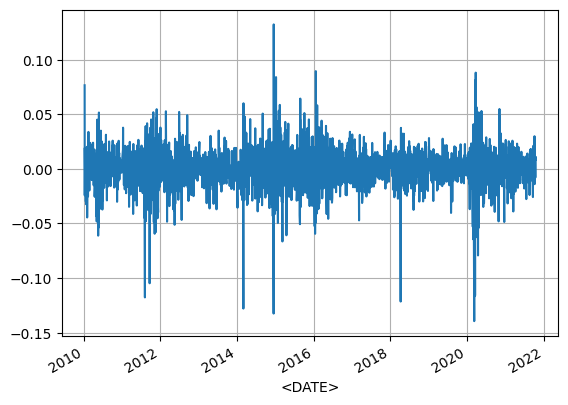

In [18]:
input_data.plot()

plt.grid()
plt.show()

In [19]:
input_data.describe()

count    2965.000000
mean        0.000091
std         0.017722
min        -0.139486
25%        -0.008678
50%         0.000601
75%         0.009209
max         0.132462
Name: log return, dtype: float64

In [20]:
n = input_data.shape[0]

In [21]:
n

2965

In [22]:
input_data.index.dayofweek + 1

Int64Index([1, 2, 3, 4, 5, 1, 2, 3, 4, 5,
            ...
            1, 2, 3, 4, 5, 1, 2, 3, 4, 5],
           dtype='int64', name='<DATE>', length=2965)

## Train / test split

In [23]:
n_train = 100  # 2000

n_test = 10
n_test = min(n - n_train, n_test)

In [24]:
train, test = input_data.iloc[:n_train].copy(), input_data.iloc[n_train:(n_train + n_test)].copy()
input_cut = pd.concat([train, test]).copy()
# data_to_cluster_train, data_to_cluster_test = days_of_week.iloc[:n_train].copy(), days_of_week.iloc[n_train:].copy()

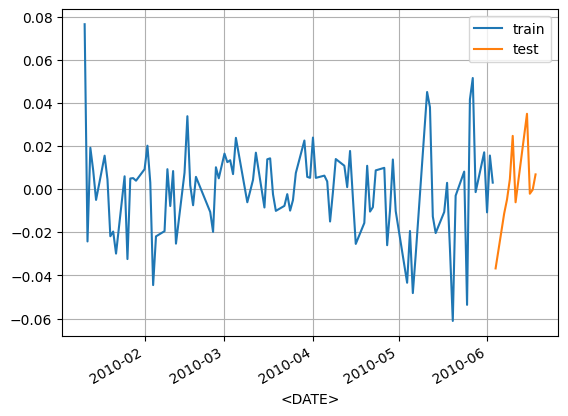

In [25]:
train.plot(label='train')
test.plot(label='test')

plt.legend()
plt.grid()
plt.show()

In [26]:
train.describe()

count    100.000000
mean      -0.000333
std        0.021419
min       -0.061136
25%       -0.010510
50%        0.003145
75%        0.010414
max        0.076686
Name: log return, dtype: float64

## Antecedent parameters

In [27]:
# set #1
clusterization_method_1 = 'trapezoidal'

n_clusters_1 = 2

a = [1, 1]
b = [1, 5]
c = [1, 5]
d = [5, 5]

# set #2
clusterization_method_2 = 'gaussian'

n_clusters_2 = 2

# variances = [7, 6, 3, 5]
# centers = [-7.5, -1.5, 1.5, 4]
variances = [7, 5]
centers = [-4.5, 2.5]

In [28]:
# rtsi['test triangular cluster memb'] = \
calc_trapezoidal_membership_degrees(2,
                                    a=a,
                                    b=b,
                                    c=c,
                                    d=d)

array([0.75, 0.25])

In [29]:
clusterization_parameters = [{'a': a, 'b': b, 'c': c, 'd': d, 'n_clusters': n_clusters_1},
                             {'centers': centers, 'variances': variances, 'n_clusters': n_clusters_2}]
clusterization_methods = [clusterization_method_1, clusterization_method_2]
n_clusters = n_clusters_1 * n_clusters_2

## Consequent parameters

In [30]:
# technical parameters for arch_model function
garch_mean = 'Zero'
garch_dist = 'normal'

# general parameters
local_method = 'garch'

# GARCH parameters
p = 1
q = 1

starting_index = max(p, q)

train_sample_std = train.std()
first_h = [train_sample_std ** 2] * starting_index
# first_h = [train[0] ** 2]  # TODO: TRY THIS
first_h = np.array(first_h)

# parameters constraints
lower_bounds = [0] * (1 + p + q) * n_clusters
upper_bounds = [+np.inf] * n_clusters + [1] * (p + q) * n_clusters
bounds = (lower_bounds, upper_bounds)

### Using classic GARCH to get initial parameters values

In [31]:
garch = arch_model(train,
                   mean=garch_mean,
                   vol='GARCH',
                   p=p,
                   q=q,
                   dist=garch_dist)
garch_fitted = garch.fit()

Iteration:      1,   Func. Count:      5,   Neg. LLF: -172.81375246629065
Iteration:      2,   Func. Count:     14,   Neg. LLF: -231.83780274495433
Iteration:      3,   Func. Count:     21,   Neg. LLF: -246.87441129590061
Iteration:      4,   Func. Count:     28,   Neg. LLF: -246.6371189750122
Iteration:      5,   Func. Count:     33,   Neg. LLF: -250.4869892567008
Iteration:      6,   Func. Count:     37,   Neg. LLF: -250.4870954083915
Iteration:      7,   Func. Count:     41,   Neg. LLF: -250.4871000056945
Iteration:      8,   Func. Count:     44,   Neg. LLF: -250.4871000055288
Optimization terminated successfully    (Exit mode 0)
            Current function value: -250.4871000056945
            Iterations: 8
            Function evaluations: 44
            Gradient evaluations: 8


/Applications/anaconda3/envs/fuzzy-volatility/lib/python3.9/site-packages/arch/univariate/base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0004542. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


In [32]:
garch_fitted.params

omega       0.000018
alpha[1]    0.116398
beta[1]     0.836906
Name: params, dtype: float64

In [33]:
alpha_0_ini = np.array([garch_fitted.params.iloc[0] for _ in range(n_clusters)])
alpha_ini = np.array([garch_fitted.params.iloc[1:(q + 1)].values for _ in range(n_clusters)])
beta_ini = np.array([garch_fitted.params.iloc[(q + 1):].values for _ in range(n_clusters)])

In [34]:
# alpha_0_ini, alpha_ini, beta_ini = unpack_1d_parameters(garch_fitted.params.values, p=p, q=q, n_clusters=n_clusters)

In [35]:
parameters_ini = {'alpha_0': alpha_0_ini, 'alpha': alpha_ini, 'beta': beta_ini}

In [36]:
parameters_ini

{'alpha_0': array([1.76128451e-05, 1.76128451e-05, 1.76128451e-05, 1.76128451e-05]),
 'alpha': array([[0.11639833],
        [0.11639833],
        [0.11639833],
        [0.11639833]]),
 'beta': array([[0.8369058],
        [0.8369058],
        [0.8369058],
        [0.8369058]])}

In [37]:
# # initial parameters values for LS to start with
# alpha_0_ini = np.array([garch_fitted.params.loc['omega']] * n_clusters)
# alpha_ini = np.array([[1] * n_clusters] * q)
# beta_ini = np.array([[1] * n_clusters] * p)
# parameters_ini = {'alpha_0': alpha_0_ini, 'alpha': alpha_ini, 'beta': beta_ini}

In [38]:
list(alpha_ini.flatten())

[0.11639832899030729,
 0.11639832899030729,
 0.11639832899030729,
 0.11639832899030729]

### Setting dict w/ all consequent parameters

In [39]:
local_method_parameters = {'p': p, 'q': q, 'mean': garch_mean, 'dist': garch_dist, 'first_h': first_h,
                           'bounds': bounds, 'parameters_ini': parameters_ini}

## Other params

In [40]:
n_last_points_to_use_for_clustering_1 = 1
n_last_points_to_use_for_clustering_2 = 10
n_last_points_to_use_for_clustering = [n_last_points_to_use_for_clustering_1, n_last_points_to_use_for_clustering_2]

In [41]:
data_to_cluster_1 = pd.Series(train.index.dayofweek + 1, index=train.index).copy()
data_to_cluster_2 = 'train'
data_to_cluster = [data_to_cluster_1, data_to_cluster_2]

In [42]:
data_to_cluster

[<DATE>
 2010-01-11    1
 2010-01-12    2
 2010-01-13    3
 2010-01-14    4
 2010-01-15    5
              ..
 2010-05-28    5
 2010-05-31    1
 2010-06-01    2
 2010-06-02    3
 2010-06-03    4
 Name: <DATE>, Length: 100, dtype: int64,
 'train']

In [43]:
cluster_sets_conjunction = 'prod'

normalize = True

n_points_fitting = 100

# Testing `FuzzyVolatilityModel` class

In [44]:
fvm = FuzzyVolatilityModel(train,
                           clusterization_method=clusterization_methods,
                           clusterization_parameters=clusterization_parameters,
                           local_method=local_method,
                           local_method_parameters=local_method_parameters,
                           n_last_points_to_use_for_clustering=n_last_points_to_use_for_clustering,
                           data_to_cluster=data_to_cluster,
                           cluster_sets_conjunction=cluster_sets_conjunction,
                           normalize=normalize,
                           n_points_fitting=n_points_fitting)

## `fit`

In [45]:
%%time

fvm.fit()

CPU times: user 24.6 s, sys: 832 ms, total: 25.5 s
Wall time: 26.8 s


In [46]:
n_last_points_to_use_for_clustering

[1, 10]

In [47]:
fvm.alpha_0

array([3.00476887e-04, 8.15978908e-07, 2.33038360e-04, 4.46792352e-04],
      dtype=float128)

In [48]:
fvm.alpha

array([[0.13931715, 0.13919586, 0.1392599 , 0.13919585]], dtype=float128)

In [49]:
fvm.beta

array([[0.0008397 , 0.00083962, 0.00083966, 0.00083962]], dtype=float128)

In [50]:
garch_fitted.params

omega       0.000018
alpha[1]    0.116398
beta[1]     0.836906
Name: params, dtype: float64

In [51]:
fvm._parameters_hist

[{'alpha_0': array([3.00476887e-04, 8.15978908e-07, 2.33038360e-04, 4.46792352e-04],
        dtype=float128),
  'alpha': array([[0.13931715, 0.13919586, 0.1392599 , 0.13919585]], dtype=float128),
  'beta': array([[0.0008397 , 0.00083962, 0.00083966, 0.00083962]], dtype=float128)}]

In [52]:
fvm.membership_degrees_current

array([1.16324806e-05, 2.49988368e-01, 3.48974419e-05, 7.49965103e-01],
      dtype=float128)

In [53]:
fvm.clusters_parameters_current

{'n_clusters': 4,
 'params by sets': [{'a': [1, 1],
   'b': [1, 5],
   'c': [1, 5],
   'd': [5, 5],
   'n_clusters': 2},
  {'centers': [-4.5, 2.5], 'variances': [7, 5], 'n_clusters': 2}]}

In [54]:
data_to_cluster

[<DATE>
 2010-01-11    1
 2010-01-12    2
 2010-01-13    3
 2010-01-14    4
 2010-01-15    5
              ..
 2010-05-28    5
 2010-05-31    1
 2010-06-01    2
 2010-06-02    3
 2010-06-03    4
 Name: <DATE>, Length: 100, dtype: int64,
 'train']

In [55]:
fvm._membership_degrees_hist

[array([1.16324806e-05, 2.49988368e-01, 3.48974419e-05, 7.49965103e-01],
       dtype=float128)]

In [56]:
fvm.train_data

<DATE>
2010-01-11    0.076686
2010-01-12   -0.024211
2010-01-13    0.019327
2010-01-14    0.008749
2010-01-15   -0.004911
                ...   
2010-05-28   -0.001298
2010-05-31    0.017188
2010-06-01   -0.010699
2010-06-02    0.015701
2010-06-03    0.003104
Name: log return, Length: 100, dtype: float64

## `forecast`

In [57]:
fvm.forecast()

In [58]:
fvm.current_output

0.00033694568276871645528

In [59]:
fvm._hist_output

[0.00033694568276871645528]

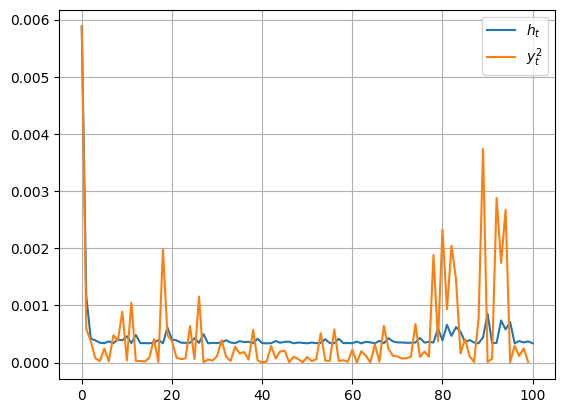

In [60]:
plt.plot(fvm.h, label='$h_t$')
plt.plot(train.values ** 2, label='$y_t^2$')

plt.legend()
plt.grid()
plt.show()

## `feed_daily_data`

In [61]:
n_test_small = 10
test_small = test.iloc[:n_test_small].copy()
input_cut = pd.concat([train, test_small]).copy()

data_to_cluster_test_1 = pd.Series(test_small.index.dayofweek + 1, index=test_small.index).copy()
data_to_cluster_test_2 = 'train'
data_to_cluster_test = [data_to_cluster_test_1, data_to_cluster_test_2]
# data_to_cluster = test_small.index.dayofweek + 1
# data_to_cluster = pd.Series(data_to_cluster, index=test_small.index)

In [62]:
data_to_cluster_test

[<DATE>
 2010-06-04    5
 2010-06-07    1
 2010-06-08    2
 2010-06-09    3
 2010-06-10    4
 2010-06-11    5
 2010-06-15    2
 2010-06-16    3
 2010-06-17    4
 2010-06-18    5
 Name: <DATE>, dtype: int64,
 'train']

In [63]:
fvm._membership_degrees_hist

[array([1.16324806e-05, 2.49988368e-01, 3.48974419e-05, 7.49965103e-01],
       dtype=float128)]

In [64]:
%%time

fvm.feed_daily_data(test_small, data_to_cluster=data_to_cluster_test)

CPU times: user 5min 20s, sys: 9.23 s, total: 5min 30s
Wall time: 5min 33s


In [65]:
fvm.data_to_cluster

,<DATE>,log return
<DATE>,,
2010-01-11,1.0,0.076686
2010-01-12,2.0,-0.024211
2010-01-13,3.0,0.019327
2010-01-14,4.0,0.008749
2010-01-15,5.0,-0.004911
...,...,...
2010-06-11,5.0,-0.006017
2010-06-15,2.0,0.035086
2010-06-16,3.0,-0.002051


In [66]:
fvm.h

array([3.66463825e-05, 7.19941539e-05, 2.30330337e-04, 2.21132293e-04,
       2.14210633e-04, 2.07396562e-04, 2.11321122e-04, 2.56168568e-04,
       2.39258033e-04, 4.80528973e-04, 4.74154340e-04, 4.56204006e-04,
       4.04794493e-04, 3.61299189e-04, 3.28994007e-04, 3.76829704e-04,
       3.39467892e-04, 4.51799800e-04, 3.90506335e-04, 3.49459109e-04,
       3.14818871e-04, 2.97829270e-04, 3.20770862e-04, 3.01730279e-04,
       2.76750430e-04, 2.89508552e-04, 2.84459550e-04, 2.83531260e-04,
       2.65687164e-04, 3.19257309e-04, 2.91672527e-04, 2.65646187e-04,
       2.47832774e-04, 2.68911424e-04, 2.57049293e-04, 2.63782249e-04,
       2.70657281e-04, 2.49885305e-04, 2.46002936e-04, 2.37662698e-04,
       2.24200306e-04, 2.25753990e-04, 2.17514539e-04, 2.15317813e-04,
       2.72556616e-04, 2.55000046e-04, 2.40725183e-04, 3.00661324e-04,
       2.76195034e-04, 2.58742865e-04, 2.41678184e-04, 2.55548861e-04,
       2.37693965e-04, 2.49146240e-04, 2.48014706e-04, 2.31740700e-04,
      

In [67]:
_.shape

(101,)

In [68]:
fvm.membership_degrees_hist

,0,1,2,3
<DATE>,,,,
2010-06-04,0.000000,0.000000,0.000048,0.999952
2010-06-07,0.000049,0.999951,0.000000,0.000000
2010-06-08,0.000035,0.749965,0.000012,0.249988
2010-06-09,0.000024,0.499976,0.000024,0.499976
2010-06-10,0.000013,0.249987,0.000038,0.749962
2010-06-11,0.000000,0.000000,0.000051,0.999949
2010-06-15,0.000037,0.749963,0.000012,0.249988
2010-06-16,0.000025,0.499975,0.000025,0.499975
2010-06-17,0.000012,0.249988,0.000037,0.749963


In [69]:
pd.DataFrame.from_records(fvm._parameters_hist, index=fvm.train_data.index[-len(fvm._parameters_hist):])

,alpha_0,alpha,beta
<DATE>,,,
2010-06-03,"[0.0003004768873716360482, 8.159789076320547131e-07, 0.00023303836013600437665, 0.0004467923518788418708]","[[0.1393171474604329266, 0.13919585750245487043, 0.13925989738326516649, 0.13919584729619864744]]","[[0.00083970464981650666484, 0.0008396198053913081291, 0.0008396628031460018702, 0.0008396197322813974395]]"
2010-06-04,"[0.00030047688737163607, 32.485150132299125, 0.5182772472914601, 3.6297681060355246e-08]","[[0.13076463828384755, 0.13471232643558845, 0.1190977116579638, 0.11834018875172624]]","[[0.0008397046498165459, 0.0008396198053913079, 0.8266163578170976, 0.8265778626048796]]"
2010-06-07,"[0.5414472385598754, 7.452580380270778e-08, 591225.9066716422, 190065.24630611963]","[[0.11352854472270325, 0.11380867504382916, 0.1190977116061962, 0.1183401886739489]]","[[0.8275334361536509, 0.827499579363573, 0.8266163578170976, 0.8265778626048796]]"
2010-06-08,"[2.0686065836931592346e-06, 5.7614207840027045583e-05, 0.0007043033704033515271, 2.1740001683463869099e-08]","[[0.13139404420633748171, 0.13295448853879177127, 0.14477367744709277607, 0.13295423916957286056]]","[[0.7676361441721162393, 0.76763558097058200315, 0.76764778822749394125, 0.7676355825296140994]]"
2010-06-09,"[0.00015171966447549279791, 1.7744200883078600587e-08, 0.00083733063096995015787, 8.6294288203331588454e-05]","[[0.13377532407480370816, 0.13546496376627888581, 0.14686541606473283574, 0.13546474194008586737]]","[[0.76207910795952176766, 0.7632620886188196366, 0.7656023062920500632, 0.7632619741969229206]]"
2010-06-10,"[8.166659173246682e-05, 9.771321370150538e-10, 0.00045078363847290807, 4.6461566291607195e-05]","[[0.12263965577194323, 0.12438301552723295, 0.1355195807391869, 0.12438312514716766]]","[[0.7926799689082021, 0.793858014843145, 0.7958904334343069, 0.7938571855348614]]"
2010-06-11,"[8.166659173246682e-05, 1.7747384852066574, 0.0004207461598515353, 4.33656502237767e-05]","[[0.02493178695929576, 0.12576681411593382, 0.1495806697586699, 0.13728851707700856]]","[[0.7926799689082021, 0.793858014843145, 0.7617910781344641, 0.7598441695780936]]"
2010-06-15,"[8.26083805708814921e-05, 4.881896203319324352e-08, 0.000113139617363689846284, 0.00012923733188706921271]","[[0.11964893821441690648, 0.1201638443572995107, 0.11624720674592981395, 0.12018388856824046913]]","[[0.8033987793640442411, 0.8031924923959917534, 0.8038415194666661644, 0.80318948358083389185]]"
2010-06-16,"[4.1461193305686204e-05, 2.4502264816887456e-08, 5.6784838571040485e-05, 6.486429039542986e-05]","[[0.11890821722591428, 0.11946372423022875, 0.11527391758845701, 0.119485120097271]]","[[0.8024663196391932, 0.8022448934346543, 0.8028184495306352, 0.8022425116850747]]"


In [70]:
fvm._ls_results_hist

[ active_mask: array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
         cost: 2.2058367932158384261e-05
          fun: array([-5.72626167e-04, -4.43381714e-05, -3.11085658e-04, -3.22162296e-04,
        -9.47380619e-05, -3.48739548e-04,  1.36602413e-04, -1.76359454e-05,
         5.01880793e-04, -4.22994489e-04,  7.08157530e-04, -4.56231785e-04,
        -3.12090663e-04, -3.23298681e-04, -2.50407436e-04,  6.30030268e-05,
        -3.82602410e-04,  1.64135476e-03, -1.33177863e-04, -2.50514724e-05,
        -3.00622075e-04, -2.87528403e-04, -2.71987045e-04,  2.90773152e-04,
        -3.64567647e-04,  8.09409890e-04, -4.92645746e-04, -2.81571302e-04,
        -3.09631566e-04, -2.29770231e-04,  3.91994954e-05, -2.85038904e-04,
        -3.24074552e-04, -6.41264081e-05, -2.14573768e-04, -1.75294234e-04,
        -3.10969798e-04,  2.29229474e-04, -3.79018502e-04, -3.39937374e-04,
        -3.16198959e-04, -4.85846879e-05, -3.04760216e-04, -1.50928695e-04,
        -1.55399234e-04, -3.59229895e-04, -2.36193

In [71]:
fvm.hist_output

2010-06-04    0.000337
2010-06-07    0.000678
2010-06-08    0.000597
2010-06-09    0.000448
2010-06-10    0.000383
2010-06-11    0.000438
2010-06-15    0.000364
2010-06-16    0.000496
2010-06-17    0.000427
2010-06-18    0.000334
dtype: float128

In [72]:
test

<DATE>
2010-06-04   -0.036744
2010-06-07   -0.011267
2010-06-08   -0.004727
2010-06-09    0.004727
2010-06-10    0.024821
2010-06-11   -0.006017
2010-06-15    0.035086
2010-06-16   -0.002051
2010-06-17   -0.000185
2010-06-18    0.006935
Name: log return, dtype: float64

In [73]:
fvm.membership_degrees_current

array([0.00000000e+00, 0.00000000e+00, 4.97406657e-05, 9.99950259e-01],
      dtype=float128)

In [74]:
fvm.clusterization_parameters

[{'a': [1, 1], 'b': [1, 5], 'c': [1, 5], 'd': [5, 5], 'n_clusters': 2},
 {'centers': [-4.5, 2.5], 'variances': [7, 5], 'n_clusters': 2}]

In [75]:
fvm._parameters_hist

[{'alpha_0': array([3.00476887e-04, 8.15978908e-07, 2.33038360e-04, 4.46792352e-04],
        dtype=float128),
  'alpha': array([[0.13931715, 0.13919586, 0.1392599 , 0.13919585]], dtype=float128),
  'beta': array([[0.0008397 , 0.00083962, 0.00083966, 0.00083962]], dtype=float128)},
 {'alpha_0': array([3.00476887e-04, 3.24851501e+01, 5.18277247e-01, 3.62976811e-08]),
  'alpha': array([[0.13076464, 0.13471233, 0.11909771, 0.11834019]]),
  'beta': array([[0.0008397 , 0.00083962, 0.82661636, 0.82657786]])},
 {'alpha_0': array([5.41447239e-01, 7.45258038e-08, 5.91225907e+05, 1.90065246e+05]),
  'alpha': array([[0.11352854, 0.11380868, 0.11909771, 0.11834019]]),
  'beta': array([[0.82753344, 0.82749958, 0.82661636, 0.82657786]])},
 {'alpha_0': array([2.06860658e-06, 5.76142078e-05, 7.04303370e-04, 2.17400017e-08],
        dtype=float128),
  'alpha': array([[0.13139404, 0.13295449, 0.14477368, 0.13295424]], dtype=float128),
  'beta': array([[0.76763614, 0.76763558, 0.76764779, 0.76763558]], dt

## Plots

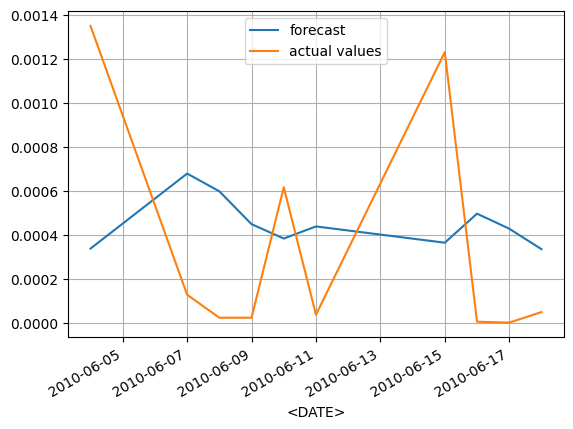

In [76]:
fvm.hist_output.plot(label='forecast')
(test_small ** 2).plot(label='actual values')

plt.legend()
plt.grid()
plt.show()

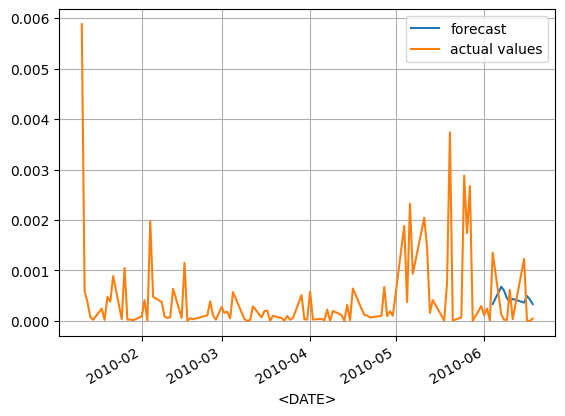

In [77]:
fvm.hist_output.plot(label='forecast')
(input_cut ** 2).plot(label='actual values')

plt.legend()
plt.grid()
plt.show()

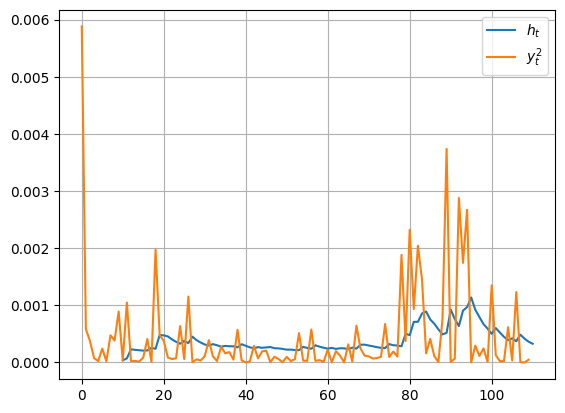

In [78]:
_h_w_nans = np.concatenate([[np.nan for _ in range(input_cut.shape[0] - n_points_fitting)], fvm.h])

plt.plot(_h_w_nans, label='$h_t$')
plt.plot(input_cut.values ** 2, label='$y_t^2$')

plt.legend()
plt.grid()
plt.show()

In [79]:
input_cut[-n_points_fitting:] ** 2

<DATE>
2010-01-25    3.664638e-05
2010-01-26    1.048939e-03
2010-01-27    2.535655e-05
2010-01-28    2.713750e-05
2010-01-29    1.605785e-05
                  ...     
2010-06-11    3.620283e-05
2010-06-15    1.231044e-03
2010-06-16    4.207162e-06
2010-06-17    3.436548e-08
2010-06-18    4.809967e-05
Name: log return, Length: 100, dtype: float64

In [81]:
fvm._h_hist

[array([0.00588077, 0.00115881, 0.00041786, 0.00038764, 0.00034628,
        0.00033894, 0.00036957, 0.0003385 , 0.00040171, 0.00038909,
        0.00045964, 0.00034078, 0.00048159, 0.00033923, 0.00033936,
        0.00033781, 0.00034774, 0.00039276, 0.00033704, 0.00061096,
        0.00040231, 0.00038815, 0.0003478 , 0.00034398, 0.0003456 ,
        0.00042417, 0.00034395, 0.00049613, 0.0003362 , 0.00034318,
        0.00034025, 0.00035096, 0.0003899 , 0.00035022, 0.00033923,
        0.00037387, 0.00035778, 0.000361  , 0.00034256, 0.00041517,
        0.00034068, 0.00033568, 0.00033829, 0.0003759 , 0.00034551,
        0.00036267, 0.00036445, 0.00033633, 0.00034951, 0.0003438 ,
        0.00033628, 0.00034922, 0.00033905, 0.00034358, 0.00040706,
        0.00034028, 0.00033955, 0.00041605, 0.00033958, 0.00034121,
        0.00033745, 0.00036667, 0.00033585, 0.00036311, 0.00035232,
        0.00033574, 0.00037975, 0.00033785, 0.00042507, 0.00036961,
        0.00035225, 0.00035047, 0.00034516, 0.00

In [82]:
fvm._hist_output

[0.00033694568276871645528,
 0.00067829413246088378195,
 0.0005974523053712622121,
 0.0004480736264805081429,
 0.00038266037097439358375,
 0.00043772235221267319284,
 0.00036369777651212903954,
 0.0004957524528545494828,
 0.00042747267531649947876,
 0.0003343984067761558502,
 0.00032780168511843855025]

In [83]:
_p = fvm._parameters_hist[-1]
_p

{'alpha_0': array([3.92131028e-05, 1.18715729e+01, 3.39349347e-05, 3.87632609e-05]),
 'alpha': array([[0.14297207, 0.14357087, 0.1247706 , 0.12926307]]),
 'beta': array([[0.7356681 , 0.73554175, 0.77799621, 0.77754241]])}

In [84]:
calc_cond_var_fuzzy(_p['alpha_0'], _p['alpha'], _p['beta'],
                    input_cut[-n_points_fitting:] ** 2, [input_cut[-n_points_fitting:][0]],
                    fvm._membership_degrees_hist[-1])

array([0.00605363, 0.00475045, 0.00386803, 0.0030496 , 0.00241346,
       0.00191741, 0.00154093, 0.00128999, 0.0010431 , 0.00110555,
       0.00096014, 0.00083408, 0.00069861, 0.00058975, 0.00050662,
       0.00051494, 0.00044686, 0.0005353 , 0.00045543, 0.00039994,
       0.00035407, 0.00032835, 0.0003445 , 0.00032018, 0.0002911 ,
       0.00030066, 0.00029313, 0.00029028, 0.00027093, 0.00032333,
       0.00029484, 0.00026811, 0.00024975, 0.0002704 , 0.00025821,
       0.00026468, 0.00027136, 0.00025043, 0.00024643, 0.00023799,
       0.00022446, 0.00022595, 0.00021767, 0.00021544, 0.00027265,
       0.00025507, 0.00024078, 0.00030071, 0.00027623, 0.00025877,
       0.0002417 , 0.00025556, 0.00023771, 0.00024916, 0.00024802,
       0.00023175, 0.00025998, 0.00024298, 0.0003108 , 0.00031196,
       0.00029679, 0.00028334, 0.00026796, 0.00025713, 0.00025158,
       0.00032148, 0.00030119, 0.00029777, 0.00028357, 0.00050264,
       0.00047796, 0.00071061, 0.00071206, 0.00085652, 0.00089

In [85]:
fvm._membership_degrees_hist[-1]

array([0.00000000e+00, 0.00000000e+00, 4.97406657e-05, 9.99950259e-01],
      dtype=float128)

## Errors

In [86]:
mean_squared_error(fvm.hist_output ** .5, test_small, squared=True)

0.00077144059197509020543

In [87]:
mean_squared_error(fvm.hist_output ** .5, test_small, squared=False)

0.027774819386903134377

In [88]:
mean_absolute_percentage_error(fvm.hist_output ** .5, test_small)

1.1522442156038568559

## RSS plots

# Model w/o seasoning

In [89]:
lower_bounds_2 = [0] * (1 + p + q) * n_clusters_2
upper_bounds_2 = [+np.inf] * n_clusters_2 + [1] * (p + q) * n_clusters_2
bounds_2 = (lower_bounds_2, upper_bounds_2)

In [90]:
alpha_0_ini_2 = np.array([garch_fitted.params.iloc[0] for _ in range(n_clusters_2)])
alpha_ini_2 = np.array([garch_fitted.params.iloc[1:(q + 1)].values for _ in range(n_clusters_2)])
beta_ini_2 = np.array([garch_fitted.params.iloc[(q + 1):].values for _ in range(n_clusters_2)])

In [91]:
parameters_ini_2 = {'alpha_0': alpha_0_ini_2, 'alpha': alpha_ini_2, 'beta': beta_ini_2}

In [92]:
local_method_parameters_2 = local_method_parameters.copy()
local_method_parameters_2['bounds'] = bounds_2
local_method_parameters_2['parameters_ini'] = parameters_ini_2

In [93]:
fvm_vanilla = FuzzyVolatilityModel(train,
                           clusterization_method=clusterization_methods[1],
                           clusterization_parameters=clusterization_parameters[1],
                           local_method=local_method,
                           local_method_parameters=local_method_parameters_2,
                           n_last_points_to_use_for_clustering=n_last_points_to_use_for_clustering[1],
                           data_to_cluster=data_to_cluster[1],
                           cluster_sets_conjunction=cluster_sets_conjunction)

## `fit`

In [94]:
%%time

fvm_vanilla.fit()

CPU times: user 8.29 s, sys: 317 ms, total: 8.61 s
Wall time: 8.82 s


In [95]:
n_last_points_to_use_for_clustering

[1, 10]

In [96]:
fvm_vanilla.alpha_0

array([3.64903352e+00, 1.65513781e-04])

In [97]:
fvm_vanilla.alpha

array([[0.13924148, 0.13919535]])

In [98]:
fvm_vanilla.beta

array([[0.0008377, 0.0008377]])

In [99]:
garch_fitted.params

omega       0.000018
alpha[1]    0.116398
beta[1]     0.836906
Name: params, dtype: float64

In [100]:
fvm_vanilla._parameters_hist

[{'alpha_0': array([3.64903352e+00, 1.65513781e-04]),
  'alpha': array([[0.13924148, 0.13919535]]),
  'beta': array([[0.0008377, 0.0008377]])}]

In [101]:
fvm_vanilla.membership_degrees_current

array([3.03608924e-15, 6.52472173e-11], dtype=float128)

In [102]:
fvm_vanilla.clusters_parameters_current

{'n_clusters': 2,
 'params by sets': [{'centers': [-4.5, 2.5],
   'variances': [7, 5],
   'n_clusters': 2}]}

In [103]:
data_to_cluster

[<DATE>
 2010-01-11    1
 2010-01-12    2
 2010-01-13    3
 2010-01-14    4
 2010-01-15    5
              ..
 2010-05-28    5
 2010-05-31    1
 2010-06-01    2
 2010-06-02    3
 2010-06-03    4
 Name: <DATE>, Length: 100, dtype: int64,
 'train']

In [104]:
fvm_vanilla._membership_degrees_hist

[array([3.03608924e-15, 6.52472173e-11], dtype=float128)]

In [105]:
fvm_vanilla.train_data

<DATE>
2010-01-11    0.076686
2010-01-12   -0.024211
2010-01-13    0.019327
2010-01-14    0.008749
2010-01-15   -0.004911
                ...   
2010-05-28   -0.001298
2010-05-31    0.017188
2010-06-01   -0.010699
2010-06-02    0.015701
2010-06-03    0.003104
Name: log return, Length: 100, dtype: float64

## `forecast`

In [106]:
fvm_vanilla.forecast()

In [107]:
fvm_vanilla.current_output

0.00033694600854447187055

In [108]:
fvm_vanilla._hist_output

[0.00033694600854447187055]

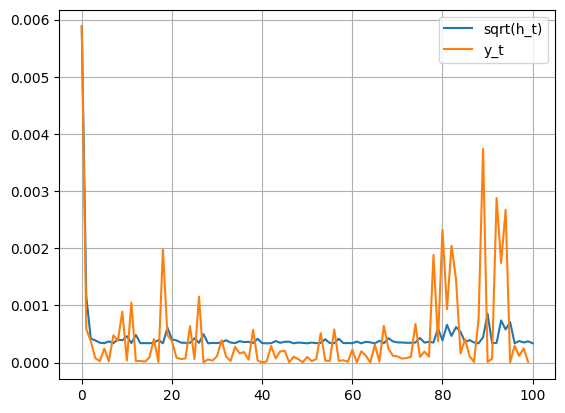

In [109]:
plt.plot(fvm_vanilla.h, label='sqrt(h_t)')
plt.plot(train.values ** 2, label='y_t')

plt.legend()
plt.grid()
plt.show()

In [110]:
fvm_vanilla.h

array([0.00588077, 0.0011588 , 0.00041786, 0.00038764, 0.00034628,
       0.00033894, 0.00036957, 0.0003385 , 0.00040171, 0.00038909,
       0.00045964, 0.00034078, 0.00048159, 0.00033923, 0.00033936,
       0.00033781, 0.00034774, 0.00039276, 0.00033704, 0.00061096,
       0.00040231, 0.00038815, 0.0003478 , 0.00034398, 0.0003456 ,
       0.00042417, 0.00034395, 0.00049613, 0.0003362 , 0.00034318,
       0.00034025, 0.00035096, 0.0003899 , 0.00035022, 0.00033923,
       0.00037387, 0.00035778, 0.000361  , 0.00034256, 0.00041517,
       0.00034068, 0.00033568, 0.00033829, 0.0003759 , 0.00034551,
       0.00036267, 0.00036445, 0.00033633, 0.00034952, 0.0003438 ,
       0.00033628, 0.00034922, 0.00033905, 0.00034358, 0.00040706,
       0.00034028, 0.00033955, 0.00041605, 0.00033958, 0.00034121,
       0.00033745, 0.00036667, 0.00033585, 0.00036311, 0.00035232,
       0.00033574, 0.00037975, 0.00033785, 0.00042507, 0.00036961,
       0.00035225, 0.00035047, 0.00034516, 0.00034637, 0.00034

## `feed_daily_data`

In [111]:
# n_test_small = 10
# test_small = test.iloc[:n_test_small].copy()
# input_cut = pd.concat([train, test_small]).copy()

# data_to_cluster_test_1 = pd.Series(test_small.index.dayofweek + 1, index=test_small.index).copy()
# data_to_cluster_test_2 = 'train'
# data_to_cluster_test = [data_to_cluster_test_1, data_to_cluster_test_2]

In [112]:
%%time

fvm_vanilla.feed_daily_data(test_small, data_to_cluster=data_to_cluster_test_2)

CPU times: user 25.2 s, sys: 1 s, total: 26.2 s
Wall time: 26.7 s


In [113]:
fvm_vanilla.data_to_cluster

<DATE>
2010-01-11    0.076686
2010-01-12   -0.024211
2010-01-13    0.019327
2010-01-14    0.008749
2010-01-15   -0.004911
                ...   
2010-06-11   -0.006017
2010-06-15    0.035086
2010-06-16   -0.002051
2010-06-17   -0.000185
2010-06-18    0.006935
Name: log return, Length: 110, dtype: float64

In [114]:
len(fvm_vanilla._hist_output)

11

In [115]:
fvm_vanilla.h

array([0.00588077, 0.00106187, 0.00041155, 0.00038543, 0.00034896,
       0.00034252, 0.00036955, 0.00034211, 0.00039791, 0.00038673,
       0.00044899, 0.00034406, 0.00046839, 0.00034267, 0.00034289,
       0.00034153, 0.00035029, 0.00039001, 0.0003408 , 0.00058255,
       0.00039824, 0.00038589, 0.00035031, 0.00034696, 0.0003484 ,
       0.00041772, 0.00034688, 0.00048122, 0.00033998, 0.00034626,
       0.00034368, 0.00035313, 0.00038748, 0.00035243, 0.00034277,
       0.00037334, 0.00035912, 0.00036197, 0.0003457 , 0.00040979,
       0.000344  , 0.00033965, 0.00034195, 0.00037514, 0.00034829,
       0.00036346, 0.00036501, 0.0003402 , 0.00035185, 0.0003468 ,
       0.00034017, 0.00035159, 0.00034261, 0.00034661, 0.00040262,
       0.00034365, 0.00034306, 0.00041056, 0.00034303, 0.00034452,
       0.0003412 , 0.00036699, 0.00033977, 0.00036385, 0.00035431,
       0.00033968, 0.00037853, 0.00034153, 0.00041853, 0.00036952,
       0.00035425, 0.00035268, 0.000348  , 0.00034907, 0.00035

In [116]:
_.shape

(111,)

In [117]:
fvm_vanilla.data_to_cluster[-10:]

<DATE>
2010-06-04   -0.036744
2010-06-07   -0.011267
2010-06-08   -0.004727
2010-06-09    0.004727
2010-06-10    0.024821
2010-06-11   -0.006017
2010-06-15    0.035086
2010-06-16   -0.002051
2010-06-17   -0.000185
2010-06-18    0.006935
Name: log return, dtype: float64

In [118]:
fvm_vanilla.membership_degrees_hist

,0,1
<DATE>,,
2010-06-04,3.102473e-15,6.414538e-11
2010-06-07,3.141613e-15,6.352235e-11
2010-06-08,3.044949e-15,6.511427e-11
2010-06-09,3.118672e-15,6.393100e-11
2010-06-10,3.173503e-15,6.309040e-11
2010-06-11,3.183136e-15,6.294151e-11
2010-06-15,3.146512e-15,6.350136e-11
2010-06-16,3.129092e-15,6.377723e-11
2010-06-17,3.161268e-15,6.327421e-11


In [119]:
fvm_vanilla.hist_output

2010-06-04    0.000337
2010-06-07    0.000528
2010-06-08    0.000363
2010-06-09    0.000346
2010-06-10    0.000342
2010-06-11    0.000422
2010-06-15    0.000344
2010-06-16    0.000502
2010-06-17    0.000348
2010-06-18    0.000343
dtype: float128

In [120]:
test

<DATE>
2010-06-04   -0.036744
2010-06-07   -0.011267
2010-06-08   -0.004727
2010-06-09    0.004727
2010-06-10    0.024821
2010-06-11   -0.006017
2010-06-15    0.035086
2010-06-16   -0.002051
2010-06-17   -0.000185
2010-06-18    0.006935
Name: log return, dtype: float64

In [121]:
fvm_vanilla.membership_degrees_current

array([3.15348153e-15, 6.33953051e-11], dtype=float128)

In [122]:
fvm_vanilla.clusterization_parameters

{'centers': [-4.5, 2.5], 'variances': [7, 5], 'n_clusters': 2}

In [123]:
fvm_vanilla._parameters_hist

[{'alpha_0': array([3.64903352e+00, 1.65513781e-04]),
  'alpha': array([[0.13924148, 0.13919535]]),
  'beta': array([[0.0008377, 0.0008377]])},
 {'alpha_0': array([7.20429374e+00, 6.17286294e-08]),
  'alpha': array([[0.13316317, 0.13313684]]),
  'beta': array([[5.96284822e-05, 5.96282366e-05]])},
 {'alpha_0': array([7.01437957e+00, 6.01013854e-08]),
  'alpha': array([[0.12787678, 0.12793395]]),
  'beta': array([[2.57319524e-07, 2.57319002e-07]])},
 {'alpha_0': array([7.17206954e+00, 7.57271199e-06]),
  'alpha': array([[0.12985422, 0.12937944]]),
  'beta': array([[2.36945333e-14, 2.38433396e-14]])},
 {'alpha_0': array([6.80148122e+00, 7.18142205e-06]),
  'alpha': array([[0.07650869, 0.1312556 ]]),
  'beta': array([[3.76575031e-13, 3.76576574e-13]])},
 {'alpha_0': array([6.66819050e+00, 7.04068552e-06]),
  'alpha': array([[0.07560887, 0.12970255]]),
  'beta': array([[1.97051420e-11, 1.97051639e-11]])},
 {'alpha_0': array([6.56784118e+00, 6.93473054e-06]),
  'alpha': array([[0.07508691, 0

### Plots

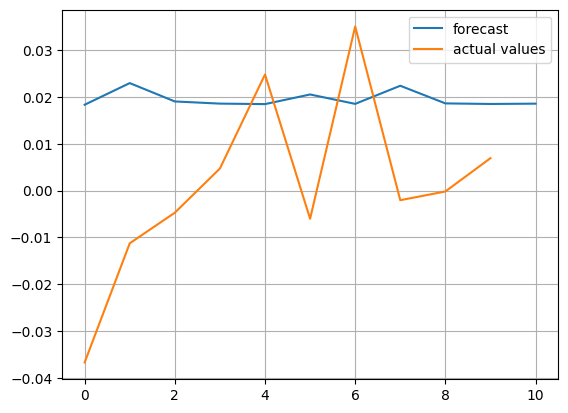

In [124]:
plt.plot((np.array(fvm_vanilla._hist_output) ** .5), label='forecast')
plt.plot(test_small.values, label='actual values')

plt.legend()
plt.grid()
plt.show()

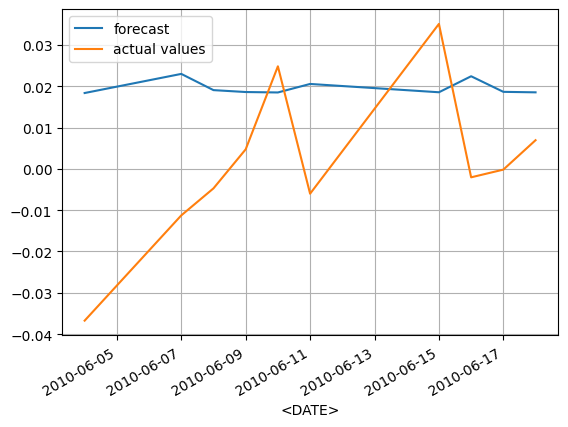

In [125]:
(fvm_vanilla.hist_output ** .5).plot(label='forecast')
test_small.plot(label='actual values')

plt.legend()
plt.grid()
plt.show()

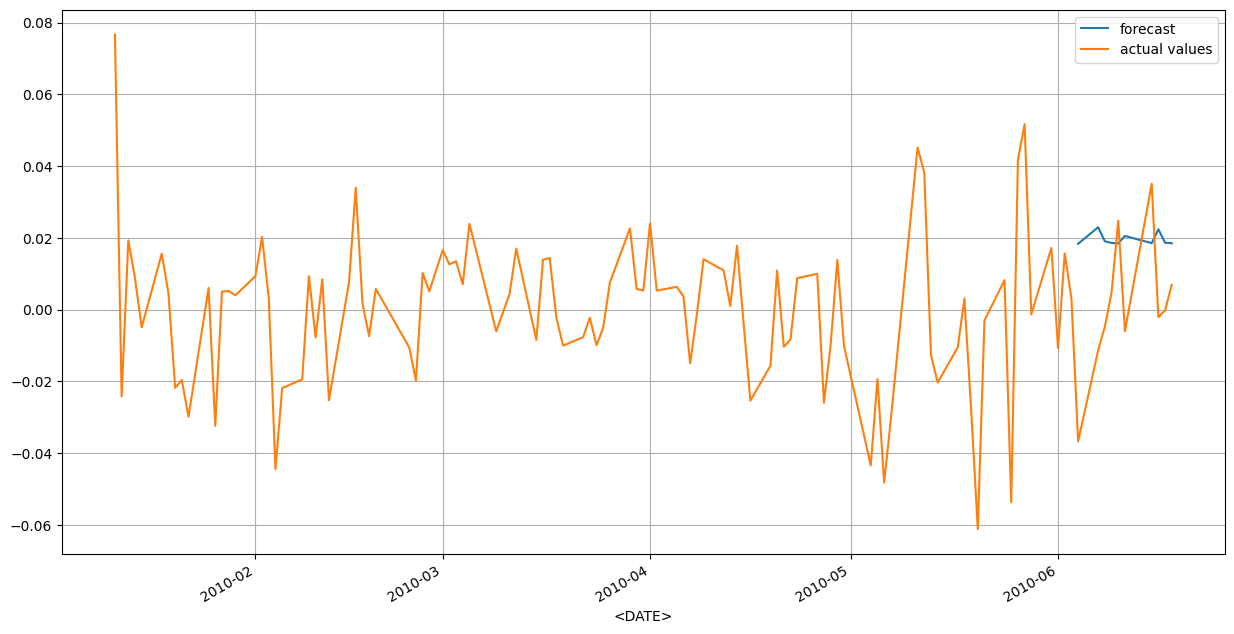

In [126]:
(fvm_vanilla.hist_output ** .5).plot(label='forecast', figsize=(15, 8))
input_cut.plot(label='actual values')

plt.legend()
plt.grid()
plt.show()

### Errors

In [127]:
mean_squared_error(fvm_vanilla.hist_output ** .5, test_small, squared=True)

0.0007074125792453843218

In [128]:
_ / mean_squared_error(fvm.hist_output ** .5, test_small, squared=True)

0.91700201752959695656

In [129]:
(_ - 1) * 100

-8.2997982470403043435

In [130]:
mean_squared_error(fvm_vanilla.hist_output ** .5, test_small, squared=False)

0.026597228788830319076

In [131]:
mean_absolute_percentage_error(fvm_vanilla.hist_output ** .5, test_small)

1.1740367526852929414

## Diff w/ seasonal model

In [132]:
np.array(fvm._hist_output) - np.array(fvm_vanilla._hist_output)

array([-3.25775755e-10,  1.50036832e-04,  2.34260269e-04,  1.02237917e-04,
        4.07743819e-05,  1.53785624e-05,  1.99597701e-05, -6.67451991e-06,
        7.99617170e-05, -8.64135047e-06, -1.76611668e-05], dtype=float128)

In [133]:
_.mean()

5.5421098779254992465e-05

## Same data fed to GARCH(1, 1)

### No retraining

In [134]:
model = arch_model(train,
                   mean=local_method_parameters['mean'],
                   vol='GARCH', p=local_method_parameters['p'],
                   q=local_method_parameters['q'],
                   dist=local_method_parameters['dist'])

In [135]:
model.volatility

GARCH(p: 1, q: 1), id: 0x7f8d65fc0490

In [136]:
fitted = model.fit()

Iteration:      1,   Func. Count:      5,   Neg. LLF: -172.81375246629065
Iteration:      2,   Func. Count:     14,   Neg. LLF: -231.83780274495433
Iteration:      3,   Func. Count:     21,   Neg. LLF: -246.87441129590061
Iteration:      4,   Func. Count:     28,   Neg. LLF: -246.6371189750122
Iteration:      5,   Func. Count:     33,   Neg. LLF: -250.4869892567008
Iteration:      6,   Func. Count:     37,   Neg. LLF: -250.4870954083915
Iteration:      7,   Func. Count:     41,   Neg. LLF: -250.4871000056945
Iteration:      8,   Func. Count:     44,   Neg. LLF: -250.4871000055288
Optimization terminated successfully    (Exit mode 0)
            Current function value: -250.4871000056945
            Iterations: 8
            Function evaluations: 44
            Gradient evaluations: 8


/Applications/anaconda3/envs/fuzzy-volatility/lib/python3.9/site-packages/arch/univariate/base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0004542. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


In [137]:
fitted.summary

<bound method ARCHModelResult.summary of                        Zero Mean - GARCH Model Results                        
Dep. Variable:             log return   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.010
Vol Model:                      GARCH   Log-Likelihood:                250.487
Distribution:                  Normal   AIC:                          -494.974
Method:            Maximum Likelihood   BIC:                          -487.159
                                        No. Observations:                  100
Date:                Wed, Sep 14 2022   Df Residuals:                      100
Time:                        23:32:05   Df Model:                            0
                              Volatility Model                              
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
omega      1.7613

In [138]:
fitted.params

omega       0.000018
alpha[1]    0.116398
beta[1]     0.836906
Name: params, dtype: float64

In [139]:
fvm.alpha_0

array([3.92131028e-05, 1.18715729e+01, 3.39349347e-05, 3.87632609e-05])

In [140]:
fvm.alpha

array([[0.14297207, 0.14357087, 0.1247706 , 0.12926307]])

In [141]:
fvm.beta

array([[0.7356681 , 0.73554175, 0.77799621, 0.77754241]])

In [142]:
forecast = fitted.forecast(reindex=False, horizon=1)

In [143]:
forecast_variance = forecast.variance.iloc[0]

In [144]:
forecast_variance

h.1    0.000595
Name: 2010-06-03 00:00:00, dtype: float64

In [145]:
simple_garch_forecasts = garch_fitted.forecast(horizon=n_test, reindex=False).variance.iloc[0].values

In [146]:
mean_squared_error(simple_garch_forecasts, test_small ** 2, squared=True)

2.901720753924943e-07

### With retraining

In [147]:
def calc_vanilla_garch_wr_mse(info, data, garch_mean, garch_vol, garch_dist):
    train_size = info.loc['Train size']
    test_size = info.loc['Test size']
    p = info.loc['p']
    q = info.loc['q']
    
    train = data[info.loc['Start date']:].iloc[:train_size]
    test = data[info.loc['Start date']:].iloc[train_size:(train_size + test_size)]
    
    forecast = calculate_retraining_garch_forecasts(train, test,
                                                    mean=garch_mean,
                                                    vol=garch_vol,
                                                    p=p,
                                                    q=q,
                                                    dist=garch_dist)
    
    mse = mean_squared_error(forecast, test ** 2, squared=True)
    
    return mse

# Bollocks

In [148]:
from multiprocessing import Pool

In [149]:
def f(length):
    arr = []
    for i in range(int(length)):
        arr.append(i + 1)
    return arr

In [150]:
%%time

arr = f(1e5)

CPU times: user 12.9 ms, sys: 2.06 ms, total: 15 ms
Wall time: 15.7 ms


# Testing clustering

## 1d

In [151]:
x = [data_to_cluster[0], data_to_cluster[0]].copy()
methods = clusterization_methods
parameters = clusterization_parameters

In [152]:
clustering_results = []
for i, (_x, _method) in enumerate(zip(x, methods)):
    _clustering_result = cluster_data_1d(_x,
                                         method=_method,
                                         parameters=parameters[i] if parameters is not None else None,
                                         n_last_points_to_use_for_clustering=n_last_points_to_use_for_clustering[i]
                                         if n_last_points_to_use_for_clustering is not None else None)
    clustering_results.append(_clustering_result)

In [153]:
[
    cluster_data_1d(_x,
                    method=_method,
                    parameters=_parameters,
                    n_last_points_to_use_for_clustering=_n_last_points_to_use_for_clustering)
    for _x, _method, _parameters, _n_last_points_to_use_for_clustering in
    zip(x, methods, parameters, n_last_points_to_use_for_clustering)
]

[{'parameters': {'a': [1, 1],
   'b': [1, 5],
   'c': [1, 5],
   'd': [5, 5],
   'n_clusters': 2},
  'membership': array([0.25, 0.75])},
 {'parameters': {'centers': [-4.5, 2.5], 'variances': [7, 5], 'n_clusters': 2},
  'membership': array([5.17437509e-27, 3.44419754e-09], dtype=float128)}]

## multidim

In [154]:
n_cluster_sets = 2

In [155]:
dtc = \
    pd.concat([pd.concat([data_to_cluster[0], data_to_cluster_test[0]]),
               pd.concat([train, test])], axis='columns').copy()

In [156]:
help(dtc.rolling)

Help on method rolling in module pandas.core.generic:

rolling(window: 'int | timedelta | BaseOffset | BaseIndexer', min_periods: 'int | None' = None, center: 'bool_t' = False, win_type: 'str | None' = None, on: 'str | None' = None, axis: 'Axis' = 0, closed: 'str | None' = None, method: 'str' = 'single') method of pandas.core.frame.DataFrame instance
    Provide rolling window calculations.
    
    Parameters
    ----------
    window : int, offset, or BaseIndexer subclass
        Size of the moving window. This is the number of observations used for
        calculating the statistic. Each window will be a fixed size.
    
        If its an offset then this will be the time period of each window. Each
        window will be a variable sized based on the observations included in
        the time-period. This is only valid for datetimelike indexes.
    
        If a BaseIndexer subclass is passed, calculates the window boundaries
        based on the defined ``get_window_bounds`` method

In [157]:
dtc.iloc[train.shape[0] - test.shape[0] - 1:].expanding(min_periods=1).apply(lambda _row: _row.shape[0])

,<DATE>,log return
<DATE>,,
2010-05-20,1.0,1.0
2010-05-21,2.0,2.0
2010-05-24,3.0,3.0
2010-05-25,4.0,4.0
2010-05-26,5.0,5.0
2010-05-27,6.0,6.0
2010-05-28,7.0,7.0
2010-05-31,8.0,8.0
2010-06-01,9.0,9.0


In [158]:
dtc.iloc[train.shape[0] - test.shape[0] - 1:].rolling(10, min_periods=1).apply(lambda _row: _row.shape[0])

,<DATE>,log return
<DATE>,,
2010-05-20,1.0,1.0
2010-05-21,2.0,2.0
2010-05-24,3.0,3.0
2010-05-25,4.0,4.0
2010-05-26,5.0,5.0
2010-05-27,6.0,6.0
2010-05-28,7.0,7.0
2010-05-31,8.0,8.0
2010-06-01,9.0,9.0


In [159]:
dtc

,<DATE>,log return
<DATE>,,
2010-01-11,1,0.076686
2010-01-12,2,-0.024211
2010-01-13,3,0.019327
2010-01-14,4,0.008749
2010-01-15,5,-0.004911
...,...,...
2010-06-11,5,-0.006017
2010-06-15,2,0.035086
2010-06-16,3,-0.002051


In [160]:
cluster_data(data_to_cluster,
             methods=clusterization_methods,
             parameters=clusterization_parameters,
             n_last_points_to_use_for_clustering=
             n_last_points_to_use_for_clustering,
             conjunction=cluster_sets_conjunction,
             n_sets=n_cluster_sets,
             normalize=normalize)

/Users/vladimirsviyazov/Documents/Study postgraduate/Thesis/fuzzy-volatility-modeling/clusterization/all_methods.py:43: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  (type(x) is list and array(x).dtype != object and len(array(x).shape) == 1) or \


AttributeError: 'str' object has no attribute 'copy'

# Testing `expanding` w/ `numba`

In [ ]:
def f(df: pd.DataFrame) -> pd.Series:
    return df.iloc[:, 0] + df.iloc[:, 1]

In [ ]:
def f2(df: np.array) -> np.array:
    return df[:, 0] + df[:, 1]

In [ ]:
def f3(df: np.array) -> np.array:
    return (df[:, 0] + df[:, 1], df[:, 0] - df[:, 1])

In [ ]:
def f4(df: np.array) -> tuple:
    return (df[:, 0].mean(), df[:, 1].mean())

In [ ]:
f(dtc)

In [ ]:
f2(dtc.values)

In [ ]:
f3(dtc.values)

In [ ]:
f4(dtc.values)

In [ ]:
dtc.expanding(method='table').apply(f4, engine='numba', raw=True)

In [ ]:
np.vstack([np.array([1, 2, 3]), np.array([4, 5, 6])]).T